<a href="https://colab.research.google.com/github/kevinpulido89/NLP/blob/master/MeLi_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeLi Datachallenge with Transformers

1. https://ml-challenge.mercadolibre.com/workshop
2. https://www.youtube.com/watch?v=tirn18qFaa8

## Librerias

In [0]:
import pandas as pd
import numpy as np

In [0]:
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Kevin
[nltk_data]     Pulido\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Kevin
[nltk_data]     Pulido\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Funcion Cleaner() y Describe()

In [0]:
# https://www.kaggle.com/procode/sif-embeddings-got-69-accuracy

def cleaner(sentence, remove_stopwords=True, stem_words=True):

    sentence = sentence.lower()
    text = re.sub("[^a-zñáéíóúü]", " ", sentence)

    if remove_stopwords:
        words = text.split()                             
        stops = set(stopwords.words("spanish"))                  
        meaningful_words =  [word for word in words if not word in stops
                                                    and not word.startswith('#')
                                                    and not word.startswith('@')
                                                    # and word != 'x'
                                                    and not len(word) <=2]

        text = " ".join(meaningful_words)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('spanish')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    return(text)
    
def describe(e):
    t = type(e)
    try:
        s = e.shape
    except:
        s = len(e)
    
    return print(t,s)

##### Cargar .CSV

In [0]:
# df = pd.read_csv('MeLI_TrainSetEspanol.csv') # OR '/content/drive/My Drive/MeLI_TrainSetEspanol.csv'
# del df['language']
# del df['label_quality']
# print(df.shape)
# df.head()

In [0]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [0]:
# Mapear una clase a un entero que lo represente: CELLPHONES --> 300
df['classes'] = LabelEncoder().fit_transform(list(df['category']))

In [0]:
df['clean_title'] = df['title'].apply(lambda x: cleaner(x))
df.head()

#### Guardar en .csv el avance del dataset

In [0]:
# del df['title']
# df.to_csv('MeLiTrainCleaned_Stemmed.csv', index=False)

#### Cargar el .csv del avance del dataset

In [0]:
df = pd.read_csv('datasets/MeLiTrainCleaned_Stemmed.csv')
describe(df)
df.sample(6)

<class 'pandas.core.frame.DataFrame'> (10000000, 3)


,category,classes,clean_title
1406356,SPARK_PLUGS,1309,buji encend fiat dens pru
3541012,MICROPHONES,957,microfon condens yeti pro verd youshar micr
8622035,MOUTHWASHES,1015,enjuag bucal colgat luminous whit
3000852,AUTOMOTIVE_SIDE_VIEW_MIRROR_GLASSES,95,vidri retrovisor izquierd peugeot partn
5363893,AUTOMOTIVE_SIDE_VIEW_MIRRORS,94,espej exterior electr
9021052,ESSENTIAL_OILS,587,just crem tea tre manuc rosalin banfield


##### Verificar cuantos valores nulos hay por columna

In [0]:
print(df.isnull().sum())
df = df.dropna()
# df_tmp = df.copy()

category          0
classes           0
clean_title    2427
dtype: int64


##### Verificar la categoria a la que pertenece un codigo de una clase

In [0]:
# Verificar la cetegoria a la que pertenece un codigo de una clase
set(df['category'][df['classes']==236])

{'CAMERAS'}

##### Verificar las oraciones a la que pertenece un codigo de una clase

In [0]:
df['clean_title'][df['classes']==1573]

41399        yogurter nuev industri nacional garanti mes
45759      yogurter buenyogur funcion blanc cott orginal
54045             yogurter enfriamient automat cuisinart
68296          tabler cort calid vent direct fabric luch
78408                                yogurter atma quilm
                               ...                      
9911123                      yogurter electron nutrichef
9937280                               yogurter atma nuev
9963145       yogurter yelm jarr vidri yogur san natural
9979197             dash mini yogurt grieg mak blanc ros
9986170                yogurter queser cuisinart mad usa
Name: clean_title, Length: 530, dtype: object

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(df.clean_title.values,
                                                  df.classes.values,
                                                  test_size = 0.2,
                                                  random_state = 17,
                                                  stratify = df.classes.values)

In [0]:
describe(X_train)
describe(y_train)

describe(X_val)
describe(y_val)

<class 'numpy.ndarray'> (7998058,)
<class 'numpy.ndarray'> (7998058,)
<class 'numpy.ndarray'> (1999515,)
<class 'numpy.ndarray'> (1999515,)


## Loading Tokenizer and Encoding the data

In [0]:
import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset

# https://huggingface.co/transformers/model_doc/auto.html#autotokenizer
from transformers import AutoTokenizer, AutoModelWithLMHead

In [0]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [0]:
encoded_data_train = tokenizer.batch_encode_plus(X_train,
                                                 add_special_tokens = True,
                                                 return_attention_masks = True,
                                                 pad_to_max_length = True,
                                                 max_length = 256,
                                                 return_tensors = 'pt')

encoded_data_val   = tokenizer.batch_encode_plus(X_val,
                                                 add_special_tokens = True,
                                                 return_attention_masks = True,
                                                 pad_to_max_length = True,
                                                 max_length = 256,
                                                 return_tensors = 'pt')

In [0]:
inputs_ids_train = encoded_data_train['input_ids']
attention_mask_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train) # df[df.data_type == 'train']['label'].values

inputs_ids_val = encoded_data_val['input_ids']
attention_mask_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val) # df[df.data_type == 'val']['label'].values

In [0]:
dataset_train = TensorDataset(inputs_ids_train,
                              attention_mask_train,
                              labels_train) # len(dataset_train) = 7998058 || torch.utils.data.dataset.TensorDataset

dataset_val = TensorDataset(inputs_ids_val,
                            attention_mask_val,
                            labels_val) # len(dataset_val) = 1999515 || torch.utils.data.dataset.TensorDataset

In [0]:
model = AutoModelWithLMHead.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

#### Arquitectura del modelo 
1. https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/
2. https://medium.com/@sakeshpusuluri123/activation-functions-and-weight-initialization-in-deep-learning-ebc326e62a5c
3. https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94
4. https://www.machinecurve.com/index.php/2019/09/16/he-xavier-initialization-activation-functions-choose-wisely/
5. https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/
6. https://keras.io/layers/advanced-activations/
7. https://mlfromscratch.com/activation-functions-explained/#/
8. https://stackoverflow.com/questions/48828478/how-do-you-use-keras-leakyrelu-in-python
9. https://www.machinecurve.com/index.php/2019/11/12/using-leaky-relu-with-keras/

- The SELU function also requires a weight initialization method called LeCun Normal,
- if you want to use dropout, you have to use a special version called Alpha Dropout --> from keras.layers.noise import AlphaDropout

In [0]:
from tensorflow.keras.layers import LeakyReLU

# now add a ReLU layer explicitly:
model.add(LeakyReLU(alpha=0.05))

# or since TF2, as @craq mentionned:
lrelu = lambda x: LeakyReLU(alpha=0.1)(x)
model.add(Conv2D(..., activation=lrelu, ...)
          
'''
In tf2.0 I had to modify that a bit: lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x) – craq Sep 16 at 21:52
to load saved model, use : keras.models.load_model("/path/to/model.h5", custom_objects = {'<lambda>': lrelu} ) – Christophorus Reyhan Nov 17 at 15:00 
'''
                    
from tf.keras.utils.generic_utils import get_custom_objects
# Add the GELU function to Keras
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
get_custom_objects().update({'gelu': Activation(gelu)})

# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

act_func = ['sigmoid', 'relu', 'elu', 'leaky-relu', 'selu', 'gelu']
          
          
if(activation == 'selu'):
          model.add(Conv2D(32, kernel_size=(3, 3),
                           activation=activation,
                           input_shape=input_shape,
                           kernel_initializer='lecun_normal')) # <---  !!!!!!!!!!!

SyntaxError: invalid syntax (<ipython-input-1-dbe07faf87cc>, line 13)

In [0]:
model_NN = Sequential(name='Neural_Network')

model_NN.add(Dense(units=125, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
model_NN.add(Dense(150, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dropout(0.25))
model_NN.add(Dense(175, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dense(250, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dense(350, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dropout(0.3))
model_NN.add(Dense(450, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dense(550, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dense(650, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dropout(0.38))
model_NN.add(Dense(750, activation='relu', kernel_initializer='he_normal'))
model_NN.add(Dense(n_clases, activation='softmax'))

# sgd = SGD(learning_rate=0.1, momentum=0.9, nesterov=True, decay=1e-2/epochs)
adam = Adam(learning_rate=0.01, decay=1e-2/10) #decay --> decaimiento del learningRate

model_NN.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam', # Adadelta
                 metrics=['accuracy']) # sparse_categorical_accuracy
                 
model_NN.summary()

Model: "Neural_Network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 125)               12625     
_________________________________________________________________
dense_93 (Dense)             (None, 150)               18900     
_________________________________________________________________
dropout_21 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 175)               26425     
_________________________________________________________________
dense_95 (Dense)             (None, 250)               44000     
_________________________________________________________________
dense_96 (Dense)             (None, 350)               87850     
_________________________________________________________________
dropout_22 (Dropout)         (None, 350)            

In [0]:
kwargs = {'epochs': 15,
          'batch_size': 6998,
          'validation_split':0.125}

history_1 = model_NN.fit(X_train,
                          Y_train,
                          **kwargs)

Train on 6998300 samples, validate on 999758 samples
Epoch 1/15
6998300/6998300 [==============================] - 60s 9us/sample - loss: 2.6090 - accuracy: 0.4777 - val_loss: 1.4535 - val_accuracy: 0.6879
Epoch 2/15
6998300/6998300 [==============================] - 59s 8us/sample - loss: 1.7305 - accuracy: 0.6249 - val_loss: 1.2984 - val_accuracy: 0.7180
Epoch 3/15
6998300/6998300 [==============================] - 59s 8us/sample - loss: 1.5789 - accuracy: 0.6558 - val_loss: 1.2175 - val_accuracy: 0.7350
Epoch 4/15
6998300/6998300 [==============================] - 59s 8us/sample - loss: 1.4999 - accuracy: 0.6719 - val_loss: 1.1649 - val_accuracy: 0.7468
Epoch 5/15
6998300/6998300 [==============================] - 60s 9us/sample - loss: 1.4501 - accuracy: 0.6820 - val_loss: 1.1416 - val_accuracy: 0.7520
Epoch 6/15
6998300/6998300 [==============================] - 60s 9us/sample - loss: 1.4147 - accuracy: 0.6892 - val_loss: 1.1280 - val_accuracy: 0.7543
Epoch 7/15
6998300/6998300 [=

In [0]:
lss, acc = model_NN.evaluate(X_test,
                               Y_test,
                               batch_size=kwargs['batch_size'])
print('Test score:', lss)
print('Test accuracy:', acc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test score: 1.047773535855088
Test accuracy: 0.7720452


#### ANN con LeakyReLU

- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
- https://keras.io/optimizers/

In [0]:
lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

model_NN2 = Sequential(name='Neural_Network_LeakyReLU')

model_NN2.add(Dense(units=125, activation=lrelu, kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
model_NN2.add(Dense(150, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dropout(0.25))
model_NN2.add(Dense(175, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dense(250, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dense(350, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dropout(0.3))
model_NN2.add(Dense(450, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dense(550, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dense(650, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dropout(0.38))
model_NN2.add(Dense(750, activation=lrelu, kernel_initializer='he_normal'))
model_NN2.add(Dense(n_clases, activation='softmax'))

# sgd = SGD(learning_rate=0.1, momentum=0.9, nesterov=True, decay=1e-2/epochs)
adam = Adam(learning_rate=0.01, decay=1e-2/10) #decay --> decaimiento del learningRate

model_NN2.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam', # Adadelta
                 metrics=['accuracy']) # sparse_categorical_accuracy
                 
model_NN2.summary()

Model: "Neural_Network_LeakyReLU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 125)               12625     
_________________________________________________________________
dense_83 (Dense)             (None, 150)               18900     
_________________________________________________________________
dropout_18 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 175)               26425     
_________________________________________________________________
dense_85 (Dense)             (None, 250)               44000     
_________________________________________________________________
dense_86 (Dense)             (None, 350)               87850     
_________________________________________________________________
dropout_19 (Dropout)         (None, 350)  

In [0]:
kwargs = {'epochs': 15,
          'batch_size': 6998,
          'validation_split':0.125}
# ,       'validation_data':(X_test,Y_test)

history_2 = model_NN2.fit(X_train,
                          Y_train,
                          **kwargs)

Train on 6998300 samples, validate on 999758 samples
Epoch 1/15
6998300/6998300 [==============================] - 61s 9us/sample - loss: 2.2066 - accuracy: 0.5548 - val_loss: 1.3021 - val_accuracy: 0.7237
Epoch 2/15
6998300/6998300 [==============================] - 60s 9us/sample - loss: 1.5086 - accuracy: 0.6748 - val_loss: 1.1756 - val_accuracy: 0.7472
Epoch 3/15
6998300/6998300 [==============================] - 60s 9us/sample - loss: 1.3870 - accuracy: 0.6986 - val_loss: 1.1119 - val_accuracy: 0.7605
Epoch 4/15
6998300/6998300 [==============================] - 60s 9us/sample - loss: 1.3219 - accuracy: 0.7113 - val_loss: 1.0765 - val_accuracy: 0.7680
Epoch 5/15
6998300/6998300 [==============================] - 61s 9us/sample - loss: 1.2791 - accuracy: 0.7198 - val_loss: 1.0533 - val_accuracy: 0.7718
Epoch 6/15
6998300/6998300 [==============================] - 61s 9us/sample - loss: 1.2484 - accuracy: 0.7262 - val_loss: 1.0301 - val_accuracy: 0.7765
Epoch 7/15
6998300/6998300 [=

In [0]:
lss2, acc2 = model_NN2.evaluate(X_test,
                                Y_test,
                                batch_size=kwargs['batch_size'])
print('Test score:', lss2)
print('Test accuracy:', acc2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test score: 0.9482711596785236
Test accuracy: 0.79404557


- https://keras.io/examples/reuters_mlp_relu_vs_selu/
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
- https://keras.io/optimizers/

In [0]:
model_NN3 = Sequential(name='Neural_Network_SeLU')

model_NN3.add(Dense(units=125, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)))
model_NN3.add(Dense(150, activation='selu', kernel_initializer='lecun_normal'))
model_NN3.add(AlphaDropout(0.25))
model_NN3.add(Dense(175, activation='selu', kernel_initializer='lecun_normal'))
model_NN3.add(Dense(250, activation='selu', kernel_initializer='lecun_normal'))
model_NN3.add(Dense(350, activation='selu', kernel_initializer='lecun_normal'))
model_NN3.add(AlphaDropout(0.3))
model_NN3.add(Dense(450, activation='selu', kernel_initializer='lecun_normal'))
model_NN3.add(Dense(550, activation='selu', kernel_initializer='lecun_normal'))
model_NN3.add(Dense(650, activation='selu', kernel_initializer='lecun_normal'))
model_NN3.add(AlphaDropout(0.38))
model_NN3.add(Dense(750, activation='selu', kernel_initializer='lecun_normal'))
# model_NN3.add(Activation('selu'))
model_NN3.add(Dense(n_clases, activation='softmax'))

# sgd = SGD(learning_rate=0.1, momentum=0.9, nesterov=True, decay=1e-2/epochs)
adam = Adam(learning_rate=0.01, decay=1e-2/10) #decay --> decaimiento del learningRate

model_NN3.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam', # Adadelta
                 metrics=['accuracy']) # sparse_categorical_accuracy
                 
model_NN3.summary()

Model: "Neural_Network_SeLU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 125)               12625     
_________________________________________________________________
dense_73 (Dense)             (None, 150)               18900     
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 150)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 175)               26425     
_________________________________________________________________
dense_75 (Dense)             (None, 250)               44000     
_________________________________________________________________
dense_76 (Dense)             (None, 350)               87850     
_________________________________________________________________
alpha_dropout_4 (AlphaDropou (None, 350)       

In [0]:
kwargs = {'epochs': 15,
          'batch_size': 6998,
          'validation_split':0.125}

history_3 = model_NN3.fit(X_train,
                          Y_train,
                          **kwargs)

Train on 6998300 samples, validate on 999758 samples
Epoch 1/15
6998300/6998300 [==============================] - 76s 11us/sample - loss: 1.9588 - accuracy: 0.5865 - val_loss: 1.6818 - val_accuracy: 0.6959
Epoch 2/15
6998300/6998300 [==============================] - 76s 11us/sample - loss: 1.7128 - accuracy: 0.6329 - val_loss: 1.6797 - val_accuracy: 0.7107
Epoch 3/15
6998300/6998300 [==============================] - 76s 11us/sample - loss: 1.6117 - accuracy: 0.6521 - val_loss: 1.6453 - val_accuracy: 0.7248
Epoch 4/15
6998300/6998300 [==============================] - 77s 11us/sample - loss: 1.5502 - accuracy: 0.6643 - val_loss: 1.5873 - val_accuracy: 0.7364
Epoch 5/15
6998300/6998300 [==============================] - 77s 11us/sample - loss: 1.5078 - accuracy: 0.6730 - val_loss: 1.7084 - val_accuracy: 0.7378
Epoch 6/15
6998300/6998300 [==============================] - 77s 11us/sample - loss: 1.4744 - accuracy: 0.6799 - val_loss: 1.7020 - val_accuracy: 0.7443
Epoch 7/15
6998300/6998

In [0]:
lss3, acc3 = model_NN3.evaluate(X_test,
                                Y_test,
                                batch_size=kwargs['batch_size'])
print('Test score:', lss3)
print('Test accuracy:', acc3)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test score: 1.7173422093245985
Test accuracy: 0.74911064


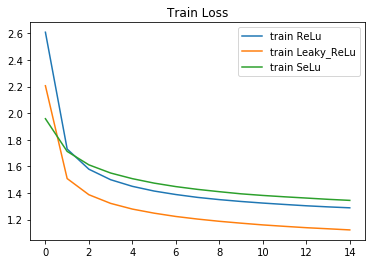

In [0]:
plt.title('Train Loss')
plt.plot(history_1.history['loss'], label='train ReLu')
plt.plot(history_2.history['loss'], label='train Leaky_ReLu')
plt.plot(history_3.history['loss'], label='train SeLu')
plt.legend()
plt.savefig('Train Loss_comparison_of_networks.png')

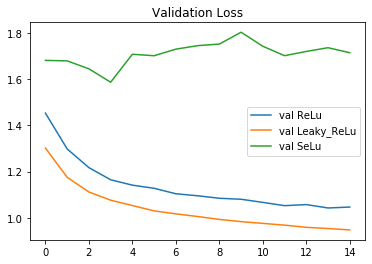

In [0]:
plt.title('Validation Loss')
plt.plot(history_1.history['val_loss'], label='val ReLu')
plt.plot(history_2.history['val_loss'], label='val Leaky_ReLu')
plt.plot(history_3.history['val_loss'], label='val SeLu')
plt.legend()
plt.savefig('Validation Loss_comparison_of_networks.png')

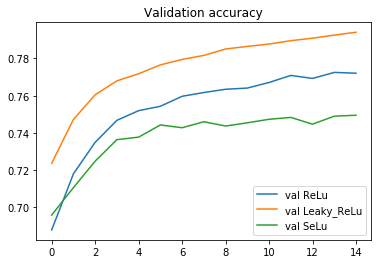

<Figure size 432x288 with 0 Axes>

In [0]:
plt.title('Validation accuracy')
plt.plot(history_1.history['val_accuracy'], label='val ReLu')
plt.plot(history_2.history['val_accuracy'], label='val Leaky_ReLu')
plt.plot(history_3.history['val_accuracy'], label='val SeLu')
plt.legend()
plt.show();
plt.savefig('Validation accuracy_comparison_of_networks.jpg')

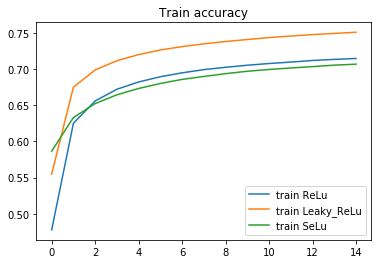

<Figure size 432x288 with 0 Axes>

In [0]:
plt.title('Train accuracy')
plt.plot(history_1.history['accuracy'], label='train ReLu')
plt.plot(history_2.history['accuracy'], label='train Leaky_ReLu')
plt.plot(history_3.history['accuracy'], label='train SeLu')
plt.legend()
plt.show();
plt.savefig('Train accuracy_comparison_of_networks.jpg')

##### Guardar/Cargar modelo ANN
<p>Guardar el modelo entrenado</p>

In [0]:
model_NN.save('model_NN_MeLi_vRELU.h5')  # creates a HDF5 file 'my_model.h5'
model_NN2.save('model_NN_MeLi_vLeakyRELU.h5')  # creates a HDF5 file 'my_model.h5'
model_NN3.save('model_NN_MeLi_SELU.h5')  # creates a HDF5 file 'my_model.h5'

<p>Cargar un modelo pre-entrenado</p>

In [0]:
# model_NN = load_model('model_NN_MeLi_vLeakyRELU.h5') # OR 'model_NN_MeLi_vRELU.h5' OR 'model_NN_MeLi_SELU.h5'

### Predict

https://www.tensorflow.org/tutorials/keras/classification

In [0]:
def predictor(model,unknown):
    '''
    A = [cleaner(u) for u in unknown]
    B = [a.split() for a in A]
    C = [(b,0) for b in B]
    D = [modelSIF.infer([c]) for c in C]
    '''
    unknown_vectors = [modelSIF.infer([c]) for c in [(b,0) for b in [a.split() for a in [cleaner(u) for u in unknown]]]]

    predicciones = list()
    for u_vect in range(len(unknown_vectors)):
        pred = model.predict(unknown_vectors[u_vect])
        predicciones.append(set(df['category'][df['classes']==np.argmax(pred)]))

    return pd.DataFrame(np.array([unknown,predicciones]).T,columns = ['Titulo desconocido','Clase predecida '+ str(model.name)])

In [0]:
unknown = ['Taladro Impacto Velocidad Variable Y Reversible Stanprof',
           'iPhone Xr 64gb 12mp/7mp 3gb Ram 4g Sellado',
           'Zapato Croydon Slimer Cr Negro Para Hombre',
           'Impresora Multifuncional Epson Ecotank L3150',
           'Celular Huawei P30 Lite 128gb 4gb Cámara Triple + Vidrio 5d',
           'Waflera Oster Ckstwf2000-1am Belgian Waffle Maker',
           'Celular Libre Xiaomi Mi 9t Versión Global 64 Gb 6 Gb Ram',
           'Guitarra Electrica Ibanez Rgew521fm-ntf',
           'Cubo Rubik Rompecabezas Cubo Rubik Mágico Carbono 3x3',
           'Cámara Semi Profesional Sony De 20.4mp Y Hi-zoom-dsc-hx400v',
           'schwarzkopf fibre force mascarilla fortificante',
           'nuevo contador billetes para detecta falsos']

In [0]:
df_prediction = pd.DataFrame(np.array(unknown),columns = ['Titulo desconocido'])
df_prediction

,Titulo desconocido
0,Taladro Impacto Velocidad Variable Y Reversibl...
1,iPhone Xr 64gb 12mp/7mp 3gb Ram 4g Sellado
2,Zapato Croydon Slimer Cr Negro Para Hombre
3,Impresora Multifuncional Epson Ecotank L3150
4,Celular Huawei P30 Lite 128gb 4gb Cámara Tripl...
5,Waflera Oster Ckstwf2000-1am Belgian Waffle Maker
6,Celular Libre Xiaomi Mi 9t Versión Global 64 G...
7,Guitarra Electrica Ibanez Rgew521fm-ntf
8,Cubo Rubik Rompecabezas Cubo Rubik Mágico Carb...
9,Cámara Semi Profesional Sony De 20.4mp Y Hi-zo...


In [0]:
df_NN1 = predictor(model_NN,unknown)
df_NN1['Clase predecida Neural_Network']

0                   {ELECTRIC_DRILLS}
1                        {CELLPHONES}
2               {LOAFERS_AND_OXFORDS}
3                          {PRINTERS}
4     {CELLPHONE_REPLACEMENT_CAMERAS}
5                   {SANDWICH_MAKERS}
6                        {CELLPHONES}
7                  {ELECTRIC_GUITARS}
8                      {PUZZLE_CUBES}
9                           {CAMERAS}
10                       {FACE_MASKS}
11                    {BILL_COUNTERS}
Name: Clase predecida Neural_Network, dtype: object

In [0]:
df_NN2 = predictor(model_NN2,unknown)
df_NN2['Clase predecida Neural_Network_LeakyReLU']

0         {ELECTRIC_DRILLS}
1              {CELLPHONES}
2     {LOAFERS_AND_OXFORDS}
3                {PRINTERS}
4              {CELLPHONES}
5           {WAFFLE_MAKERS}
6              {CELLPHONES}
7        {ELECTRIC_GUITARS}
8            {PUZZLE_CUBES}
9                 {CAMERAS}
10             {FACE_MASKS}
11          {BILL_COUNTERS}
Name: Clase predecida Neural_Network_LeakyReLU, dtype: object

In [0]:
df_NN3 = predictor(model_NN3,unknown)
df_NN3['Clase predecida Neural_Network_SeLU']

0                                {ELECTRIC_DRILLS}
1                                     {CELLPHONES}
2                            {LOAFERS_AND_OXFORDS}
3                                       {PRINTERS}
4     {CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS}
5                                {SANDWICH_MAKERS}
6                                     {CELLPHONES}
7                               {ELECTRIC_GUITARS}
8                                   {PUZZLE_CUBES}
9                                        {CAMERAS}
10                                    {FACE_MASKS}
11                                 {BILL_COUNTERS}
Name: Clase predecida Neural_Network_SeLU, dtype: object

In [0]:
df_prediction = pd.merge(df_prediction, df_NN1, on='Titulo desconocido')
df_prediction = pd.merge(df_prediction, df_NN2, on='Titulo desconocido')
df_prediction = pd.merge(df_prediction, df_NN3, on='Titulo desconocido')
df_prediction

,Titulo desconocido,Clase predecida Neural_Network,Clase predecida Neural_Network_LeakyReLU,Clase predecida Neural_Network_SeLU
0,Taladro Impacto Velocidad Variable Y Reversibl...,{ELECTRIC_DRILLS},{ELECTRIC_DRILLS},{ELECTRIC_DRILLS}
1,iPhone Xr 64gb 12mp/7mp 3gb Ram 4g Sellado,{CELLPHONES},{CELLPHONES},{CELLPHONES}
2,Zapato Croydon Slimer Cr Negro Para Hombre,{LOAFERS_AND_OXFORDS},{LOAFERS_AND_OXFORDS},{LOAFERS_AND_OXFORDS}
3,Impresora Multifuncional Epson Ecotank L3150,{PRINTERS},{PRINTERS},{PRINTERS}
4,Celular Huawei P30 Lite 128gb 4gb Cámara Tripl...,{CELLPHONE_REPLACEMENT_CAMERAS},{CELLPHONES},{CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS}
5,Waflera Oster Ckstwf2000-1am Belgian Waffle Maker,{SANDWICH_MAKERS},{WAFFLE_MAKERS},{SANDWICH_MAKERS}
6,Celular Libre Xiaomi Mi 9t Versión Global 64 G...,{CELLPHONES},{CELLPHONES},{CELLPHONES}
7,Guitarra Electrica Ibanez Rgew521fm-ntf,{ELECTRIC_GUITARS},{ELECTRIC_GUITARS},{ELECTRIC_GUITARS}
8,Cubo Rubik Rompecabezas Cubo Rubik Mágico Carb...,{PUZZLE_CUBES},{PUZZLE_CUBES},{PUZZLE_CUBES}
9,Cámara Semi Profesional Sony De 20.4mp Y Hi-zo...,{CAMERAS},{CAMERAS},{CAMERAS}


In [0]:
df_prediction.columns = ['Titulo desconocido','Neural_Network_ReLU','Neural_Network_LeakyReLU','Neural_Network_SeLU']
df_prediction

,Titulo desconocido,Neural_Network_ReLU,Neural_Network_LeakyReLU,Neural_Network_SeLU
0,Taladro Impacto Velocidad Variable Y Reversibl...,{ELECTRIC_DRILLS},{ELECTRIC_DRILLS},{ELECTRIC_DRILLS}
1,iPhone Xr 64gb 12mp/7mp 3gb Ram 4g Sellado,{CELLPHONES},{CELLPHONES},{CELLPHONES}
2,Zapato Croydon Slimer Cr Negro Para Hombre,{LOAFERS_AND_OXFORDS},{LOAFERS_AND_OXFORDS},{LOAFERS_AND_OXFORDS}
3,Impresora Multifuncional Epson Ecotank L3150,{PRINTERS},{PRINTERS},{PRINTERS}
4,Celular Huawei P30 Lite 128gb 4gb Cámara Tripl...,{CELLPHONE_REPLACEMENT_CAMERAS},{CELLPHONES},{CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS}
5,Waflera Oster Ckstwf2000-1am Belgian Waffle Maker,{SANDWICH_MAKERS},{WAFFLE_MAKERS},{SANDWICH_MAKERS}
6,Celular Libre Xiaomi Mi 9t Versión Global 64 G...,{CELLPHONES},{CELLPHONES},{CELLPHONES}
7,Guitarra Electrica Ibanez Rgew521fm-ntf,{ELECTRIC_GUITARS},{ELECTRIC_GUITARS},{ELECTRIC_GUITARS}
8,Cubo Rubik Rompecabezas Cubo Rubik Mágico Carb...,{PUZZLE_CUBES},{PUZZLE_CUBES},{PUZZLE_CUBES}
9,Cámara Semi Profesional Sony De 20.4mp Y Hi-zo...,{CAMERAS},{CAMERAS},{CAMERAS}


In [0]:
# def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
#     def create_model():
#         # Create model
#         model = Sequential(name=name)
#         for i in range(n):
#             model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
#         model.add(Dropout(0.38))
#         model.add(Dense(output_dim, activation='softmax'))

#         # Compile model
#         model.compile(loss='categorical_crossentropy', 
#                       optimizer='adam', 
#                       metrics=['accuracy'])
#         return model
#     return create_model

# models = [create_custom_model(n_features, n_classes, nodes=10, n=i, name='model_{}'.format(i-1)) for i in range(2, 6)]

# for create_model in models:
#     create_model().summary()

### LSTM

*   https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
*   https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
*   https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e
*   https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/
*   https://heartbeat.fritz.ai/a-beginners-guide-to-implementing-long-short-term-memory-networks-lstm-eb7a2ff09a27
*   https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
*   https://github.com/jasonwu0731/Sentiment-Analysis/blob/master/LSTM-Model/model.py
*   https://github.com/jbarnesspain/sota_sentiment/blob/master/lstm_bilstm.py
*   https://www.programcreek.com/python/example/89708/keras.layers.LSTM
*   https://github.com/jasonwu0731/Sentiment-Analysis/blob/master/LSTM-Model/train.py
*   https://github.com/happynoom/DeepTrade_keras/blob/master/windpuller.py

In [0]:
class model_LSTM():

    def __init__(self,
                 name,
                 n_classes,  #len(df['category'].unique()) OR Y_train.shape[1]
                 vocab_size, #MAX_NB_WORDS
                 max_len,    #X.shape[1]
                 embedding_size, # EMBEDDING_DIM
                 num_units = 128,
                 useBiDirection=False,
                 useAttention=False,
                 Spatial_Dropout=True,
                 learning_rate=0.001,
                 dropout=0.38,
                 recurrent_dropout=0.25,
                 return_sequences = True,
                 optimizer='adam'): # OR 'SGD','Adadelta'
        
        
        self.model = Sequential(name=name)
        self.model.add(Embedding(input_dim=vocab_size, 
                                 output_dim=embedding_size,
                                 input_length=max_len))
        
        if Spatial_Dropout:
            self.model.add(SpatialDropout1D(0.20))
            
        #Capa LSTM de plantilla
        lstm_model = LSTM(max_len, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences = return_sequences)
        
        if useBiDirection:
            lstm_model = Bidirectional(lstm_model)
        
        #Agrega capa LSTM elegida en el paso anterior, Bidereccional o Sencilla
        self.model.add(lstm_model)
            
        #Agrega una capa más LSTM
        if return_sequences:
            self.model.add(LSTM(max_len, return_sequences = False))

        # Flatten para terminar con una Red Neuronal de 2 capas ocultas
        self.model.add(Dense(max_len*20, activation='relu', kernel_initializer='he_normal'))
        self.model.add(Dense(max_len*40, activation='relu', kernel_initializer='he_normal'))
        self.model.add(Dropout(dropout))
        self.model.add(Dense(max_len*80, activation='relu', kernel_initializer='he_normal'))
        
        #Ultima capa
        self.model.add(Dense(n_classes, activation='softmax'))
        
        self.model.compile(loss='sparse_categorical_crossentropy',
                           optimizer=optimizer,
                           metrics=['accuracy'])
        self.model.summary()

In [0]:
size = 0
for l in clean_sentences:
    if len(l)>size:
        size=len(l)
        
print(f'valor de size: {size}') #El tamaño del titutar más largo encontrado en el corpus

valor de size: 20


In [0]:
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = size

# This is fixed.
EMBEDDING_DIM = size*1.25

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_title'].values)

XX = tokenizer.texts_to_sequences(df['clean_title'].values)
XX = pad_sequences(XX, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
describe(word_index)

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = len(word_index)

YY = np.array(df['classes'])

In [0]:
X_RNN_train, X_RNN_test, Y_RNN_train, Y_RNN_test = train_test_split(XX,
                                                                    YY, #Las clases de los elementos
                                                                    test_size = 0.20,
                                                                    random_state = 42)
print('Done...')

n_clases = len(df['category'].unique())

print('Tamaño de X_train:', X_RNN_train.shape)
print('Tamaño de Y_train:', Y_RNN_train.shape)

print('Tamaño de X_test:', X_RNN_test.shape)
print('Tamaño de Y_test:', Y_RNN_test.shape)

print('Número de clases:', n_clases)

Done...
Tamaño de X_train: (7998058, 20)
Tamaño de Y_train: (7998058,)
Tamaño de X_test: (1999515, 20)
Tamaño de Y_test: (1999515,)
Número de clases: 1574


In [0]:
# print('Features de entrada: {}, Categorias de salida: {}'.format(X_RNN_train.shape[1], Y_RNN_train.shape[1]))
print(f'Features de entrada: {X_RNN_train.shape[1]}, Numero de muestras de entrenamiento: {Y_RNN_train.shape[0]} Categorias de salida: {n_clases}')

Features de entrada: 20, Numero de muestras de entrenamiento: 7998058 Categorias de salida: 1574


### Set-up Arquitecture

In [0]:
kwargs = {'n_classes':n_clases, #OR Y_train.shape[1] cuando es hotencoding
          'vocab_size':MAX_NB_WORDS,
          'embedding_size': int(EMBEDDING_DIM),
          'max_len' : X_RNN_train.shape[1],
          'num_units' : 128,
          'useBiDirection': False,
          'Spatial_Dropout':True,
          'learning_rate':  0.001,
          'dropout': 0.38,
          'recurrent_dropout': 0.25,
          'return_sequences' : False,
          'optimizer':'adam' # OR 'SGD','Adadelta'}
          }

model_LSTMv1 = model_LSTM(name = 'LSTMv1', **kwargs)

Model: "LSTMv1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 20, 25)            10285925  
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 20, 25)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3680      
_________________________________________________________________
dense_14 (Dense)             (None, 400)               8400      
_________________________________________________________________
dense_15 (Dense)             (None, 800)               320800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1600)              12816

In [0]:
kwargs = {'n_classes':n_clases, #OR Y_train.shape[1] cuando es hotencoding
          'vocab_size':MAX_NB_WORDS,
          'embedding_size': int(EMBEDDING_DIM),
          'max_len' : X_RNN_train.shape[1],
          'num_units' : 128,
          'useBiDirection': True,
          'Spatial_Dropout':True,
          'learning_rate':  0.001,
          'dropout': 0.38,
          'recurrent_dropout': 0.25,
          'return_sequences' : True,
          'optimizer':'adam' # OR 'SGD','Adadelta'}
          }

model_LSTM_Bi = model_LSTM(name = 'LSTM_Bi', **kwargs)

Model: "LSTM_Bi"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 20, 25)            10285925  
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 20, 25)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 20, 40)            7360      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_10 (Dense)             (None, 400)               8400      
_________________________________________________________________
dense_11 (Dense)             (None, 800)               320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 800)               0   

In [0]:
# n_timesteps = 10
# results = DataFrame()

# # lstm forwards
# model = get_lstm_model(n_timesteps, False)
# results['lstm_forw'] = train_model(model, n_timesteps)

# # lstm backwards
# model = get_lstm_model(n_timesteps, True)
# results['lstm_back'] = train_model(model, n_timesteps)

# # bidirectional concat
# model = get_bi_lstm_model(n_timesteps, 'concat')
# results['bilstm_con'] = train_model(model, n_timesteps)

# # line plot of results
# results.plot()
# pyplot.show()

### Train

In [0]:
def train_model(Models, epochs, batch_size, X_train, Y_train):
    loss = list()
    val_loss = list()
    acc = list()
    val_acc = list()
    history = list()
    
    for model in Models:
        # fit model for one epoch on this sequence
        
        print('\nEntrenado la red: ' + str(model.model.name) +'\n')
        
        hist = model.model.fit(X_train,
                               Y_train,
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=1,
                               validation_split=0.1,
                               callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])# 
        
#         loss.append(hist.history['loss'])
#         val_loss.append(hist.history['val_loss'])
#         acc.append(hist.history['accuracy'])
#         val_acc.append(hist.history['val_accuracy'])
        history.append(hist.history)
  
    return history

In [0]:
epochs = 10
batch_size = 12496
Pred = np.array(Y_RNN_train)

Models = [model_LSTMv1, model_LSTM_Bi]

histories = train_model(Models,
                        epochs,
                        batch_size,
                        X_train=X_RNN_train,
                        Y_train=Y_RNN_train)


Entrenado la red: LSTMv1

Train on 7198252 samples, validate on 799806 samples
Epoch 1/10
7198252/7198252 [==============================] - 107s 15us/sample - loss: 3.1706 - accuracy: 0.3376 - val_loss: 1.8243 - val_accuracy: 0.6625
Epoch 2/10
7198252/7198252 [==============================] - 104s 15us/sample - loss: 3.1196 - accuracy: 0.3489 - val_loss: 1.7842 - val_accuracy: 0.6705
Epoch 3/10
7198252/7198252 [==============================] - 105s 15us/sample - loss: 3.0725 - accuracy: 0.3596 - val_loss: 1.7506 - val_accuracy: 0.6754
Epoch 4/10
7198252/7198252 [==============================] - 106s 15us/sample - loss: 3.0328 - accuracy: 0.3688 - val_loss: 1.7260 - val_accuracy: 0.6794
Epoch 5/10
7198252/7198252 [==============================] - 105s 15us/sample - loss: 2.9947 - accuracy: 0.3778 - val_loss: 1.7038 - val_accuracy: 0.6840
Epoch 6/10
7198252/7198252 [==============================] - 105s 15us/sample - loss: 2.9607 - accuracy: 0.3861 - val_loss: 1.6845 - val_accurac

ValueError: not enough values to unpack (expected 5, got 2)

##### Evaluate

In [0]:
print(model_LSTM_Bi.model.metrics_names)
lss, accr = model_LSTMv1.model.evaluate(X_RNN_test,
                                        Y_RNN_test,
                                        batch_size = 100)

In [0]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

##### Predict

In [0]:
unknown = ['Taladro Impacto Velocidad Variable Y Reversible Stanprof',
           'iPhone Xr 64gb 12mp/7mp 3gb Ram 4g Sellado',
           'Zapato Croydon Slimer Cr Negro Para Hombre',
           'Impresora Multifuncional Epson Ecotank L3150',
           'Celular Huawei P30 Lite 128gb 4gb Cámara Triple + Vidrio 5d',
           'Waflera Oster Ckstwf2000-1am Belgian Waffle Maker',
           'Celular Libre Xiaomi Mi 9t Versión Global 64 Gb 6 Gb Ram',
           'Guitarra Electrica Ibanez Rgew521fm-ntf',
           'Cubo Rubik Rompecabezas Cubo Rubik Mágico Carbono 3x3',
           'Cámara Semi Profesional Sony De 20.4mp Y Hi-zoom-dsc-hx400v',
           'schwarzkopf fibre force mascarilla fortificante',
           'nuevo contador billetes para detecta falsos']

In [0]:
new_complaint = ['Cubo Rubik Rompecabezas Cubo Rubik Mágico Carbono 3x3']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

pred = model_LSTMv1.model.predict(padded)

# labels = list(df['category'].unique())
print(set(df['category'][df['classes']==np.argmax(pred)]))
print(labels[np.argmax(pred)])

{'PUZZLE_CUBES'}
BASEBOARDS


In [0]:
import numpy as np

In [0]:
t = np.asarray([np.asarray([[0,1],
                            [1,2],
                            [1,2]])])
t

array([[[0, 1],
        [1, 2],
        [1, 2]]])

In [0]:
t.shape

(1, 3, 2)

In [0]:
n = [[0,0],[1,1],[2,2],[3,3]]
m = np.array(n)
m

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3]])

In [0]:
m.shape

(4, 2)

In [0]:
w = np.asarray([m])
w

array([[[0, 0],
        [1, 1],
        [2, 2],
        [3, 3]]])

In [0]:
w.shape

(1, 4, 2)

#### GRU

https://medium.com/@david.campion/text-generation-using-bidirectional-lstm-and-doc2vec-models-1-3-8979eb65cb3a

In [0]:
lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

n_classes=n_clases
vocab_size=MAX_NB_WORDS
max_len=X_RNN_train.shape[1]  
embedding_size=int(EMBEDDING_DIM)
num_units = 128,
useBiDirection=False,
# useAttention=False,
Spatial_Dropout=False,
# learning_rate=0.001,
dropout=0.38,
recurrent_dropout=0.25,
return_sequences = True,
optimizer='adam' # OR 'SGD','Adadelta'

      
model_GRU = Sequential(name='GRU')
model_GRU.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size,
                        input_length=max_len))
        
if Spatial_Dropout:
    model_GRU.add(SpatialDropout1D(0.20))
            
#Capa GRU de plantilla
gru_model = GRU(embedding_size, dropout=0.3, recurrent_dropout=0.25, activation="selu", return_sequences = return_sequences, kernel_initializer='lecun_normal')

if useBiDirection:
    gru_model = Bidirectional(gru_model) #, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences = return_sequences
    
#Agrega capa GRU elegida en el paso anterior, Bidereccional o Sencilla
model_GRU.add(gru_model)
model_GRU.add(GRU(embedding_size, return_sequences = return_sequences))
            
#Agrega una capa más GRU
if return_sequences:
    model_GRU.add(GRU(embedding_size, return_sequences = False))

# Flatten para terminar con una Red Neuronal de 2 capas ocultas
model_GRU.add(Dense(embedding_size*15, activation=lrelu, kernel_initializer='he_normal'))
model_GRU.add(Dense(embedding_size*30, activation=lrelu, kernel_initializer='he_normal'))
# model_GRU.add(AlphaDropout(0.38)) Con SeLu
model_GRU.add(Dropout(0.38))
model_GRU.add(Dense(embedding_size*60, activation=lrelu, kernel_initializer='he_normal'))
        
#Ultima capa
model_GRU.add(Dense(n_classes, activation='softmax'))
        
model_GRU.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy']) #Categorical accuracy

model_GRU.summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 20, 25)            10285925  
_________________________________________________________________
spatial_dropout1d_35 (Spatia (None, 20, 25)            0         
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 20, 40)            5640      
_________________________________________________________________
gru_55 (GRU)                 (None, 250)               219000    
_________________________________________________________________
dense_67 (Dense)             (None, 524)               131524    
_________________________________________________________________
dropout_14 (Dropout)         (None, 524)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 787)               413175  

In [0]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
# tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

print('Done')

1 Physical GPUs, 1 Logical GPUs
Physical devices cannot be modified after being initialized
Done


In [0]:
epochs = 10
batch_size = 12496

historyGRU= model_GRU.fit(X_RNN_train,
                          Y_RNN_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1,
                          validation_split=0.1
                          )# callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)]

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
np.argmax(pred)

In [0]:
# Verificar la cetegoria a la que pertenece un codigo de una clase
set(df['category'][df['classes']==245])